<a href="https://colab.research.google.com/github/changsin/ClassifyImages/blob/main/notebooks/clustering_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Images

Clustering is a popular unsupervised learning algorithm often used in preprocessing data. To cluster similar items in the same group, two things are needed:

1. Features: Features are decided according to data types and purposes. Regardless of data type and features, they all need to be represented in vectors.
2. Distance functions: once the features are decided and converted into vector forms, you have to decide which distance function you want to use to measure the distance between two feature vectors. Popular distance functions are: Euclidean, Cosine, Manhattan, and Hamming.

In our case, the data types are images so we can use either pixel values or structures in images. For distance functions, we will try Euclidean and Cosine functions to compare the differences. 

## The Dataset
For the experiment, I downloaded twelve car images from [unsplash](https://unsplash.com/). Here is the breakdown:

- 1 Audi
- 3 Ferraris
- 8 Volkswagen Beetles

Ideally, we want to see Ferraris and Beetles to belong to their own clusters at least. One Audi is included to see if it belongs to which cluster. Visually, it looks similar to a Ferrari, but that is a subjective judgement.

In [ ]:
!git clone https://github.com/changsin/DLTrafficCounter

fatal: destination path 'DLTrafficCounter' already exists and is not an empty directory.


The sample data downloaded and resized to be included in this repository.

In [1]:
!git clone https://github.com/changsin/ClassifyImages

Cloning into 'ClassifyImages'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 120 (delta 38), reused 74 (delta 14), pack-reused 0
Receiving objects: 100% (120/120), 12.05 MiB | 16.23 MiB/s, done.
Resolving deltas: 100% (38/38), done.


## Load and visualize images
Let's first load and visualize the data.

In [16]:
import argparse
import glob
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from scipy.spatial.distance import cdist
from sklearn import preprocessing  # to normalise existing X
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

"""
Methods for loading and visualizing images
"""

IMAGE_SIZE = 320

def glob_files(folder, file_type='*'):
    search_string = os.path.join(folder, file_type)
    files = glob.glob(search_string)

    # print('searching ', path)
    paths = []
    for f in files:
      if os.path.isdir(f):
        sub_paths = glob_files(f + '/')
        paths += sub_paths
      else:
        paths.append(f)

    # We sort the images in alphabetical order to match them
    #  to the annotation files
    paths.sort()

    return paths

def load_images(path, file_type="*"):
    files = glob_files(path, file_type)

    images = []
    for file in files:
        print(file)
        image = cv2.imread(file)
        if image is not None:
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            # normalize
            image = image / 256
            images.append(image)
        else:
            print(file, ' is not an image file')

    return np.array(images)

def plot_images(X, idx=None, limit=20):
  fig = plt.figure(figsize=(50,60))

  # The number of images for plotting is limited to 50
  end_id = len(X) if len(X) < limit else limit
  if idx is None:
    idx = range(0, end_id)

  i = 0
  for id in idx:
    axis = fig.add_subplot(5, 5, i+1)
    plt.axis('off')
    image = X[id]
    plt.imshow(image)
    i += 1
  
  return fig

In [ ]:
data_path = '/content/ClassifyImages/data/cars'
images = load_images(data_path)
images.shape
plot_images(images)

/content/ClassifyImages/data/cars/audi.brandon-atchison-eBJWhlqWR54-unsplash.jpg
/content/ClassifyImages/data/cars/ferrari.goh-rhy-yan-f_SDCASisgs-unsplash.jpg
/content/ClassifyImages/data/cars/ferrari.lance-asper-dxJ80oNvnhE-unsplash.jpg
/content/ClassifyImages/data/cars/ferrari.martin-katler-WTN4tbN_tNQ-unsplash.jpg
/content/ClassifyImages/data/cars/vw.chris-barbalis-699z9mRKlA8-unsplash.jpg
/content/ClassifyImages/data/cars/vw.christer-ehrling-5eiFysR9B8k-unsplash.jpg
/content/ClassifyImages/data/cars/vw.dan-gold-N7RiDzfF2iw-unsplash.jpg
/content/ClassifyImages/data/cars/vw.dan-gold-Q_2p94h8rjI-unsplash.jpg
/content/ClassifyImages/data/cars/vw.emil-diallo-H-Y7mdumq1w-unsplash.jpg
/content/ClassifyImages/data/cars/vw.martin-katler-V58Dl1fv42c-unsplash.jpg
/content/ClassifyImages/data/cars/vw.moriah-wolfe-75_17YO8i5s-unsplash.jpg
/content/ClassifyImages/data/cars/vw.tom-arrowsmith-7HNftpNvqho-unsplash.jpg


(12, 320, 320, 3)

In [3]:
def get_pca_reduced(X_features, dimensions=2):
  X_features_flatten = X_features.reshape(X_features.shape[0], -1)
  pca = PCA(dimensions)

  X_features_pca_reduced = pca.fit_transform(X_features_flatten)

  return X_features_pca_reduced, pca


def get_clusters(X_reduced, K):
  kmeans = KMeans(n_clusters=K, random_state=0)
  X_clusters = kmeans.fit(X_reduced)

  return X_clusters, kmeans

def to_cluster_idx(cluster_labels, bins):
    """
    param labels: cluster labels
    param bins: range of K
    returns: dictionary of cluster IDs
    """
    cluster_dict = dict()
    for cluster_id in bins:
        cluster_dict[cluster_id] = np.where(cluster_labels == cluster_id)[0]
    return cluster_dict

def cluster_images(folder, K=2):
    X_fm, filenames = to_feature_maps(folder, file_type=file_type)
    print("####", X_fm.shape)

    # normalize to use cosine similarity
    X_fm_normalized = preprocessing.normalize(X_fm.reshape(len(X_fm), -1))

    print(X_fm_normalized.shape)

    # dimensionality reduction through PCA
    X_reduced, pca = get_pca_reduced(X_fm_normalized, dimensions=K)

    return X_reduced, pca

In [ ]:
def find_duplicates(X_train_pca, threshold=0.1):
    # Calculate distances of all points
    distances = cdist(X_train_pca, X_train_pca)

    # Find duplicates (very similar images)
    # dupes = np.array([np.where(distances[id] < 1) for id in range(distances.shape[0])]).reshape(-1)
    dupes = [np.array(np.where(distances[id] < threshold)).reshape(-1).tolist() \
            for id in range(distances.shape[0])]

    to_remove = set()
    for d in dupes:
        if len(d) > 1:
            for id in range(1, len(d)):
                to_remove.add(d[id])
    logger.info("Found {} duplicates".format(len(to_remove)))
    return to_remove

In [ ]:
import matplotlib.pyplot as plt

def plot_pca_clusters(X_train_pca, kmeans):
    # kmeans, X_train_pca_clusters = get_clusters(X_train_pca)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .05     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(2)
    # plt.clf()
    plt.imshow(Z, interpolation="nearest",
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                cmap=plt.cm.Paired, aspect="auto", origin="lower")

    plt.plot(X_train_pca[:, 0], X_train_pca[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_

    # markers = ["o", "1", "2", "3", "4"]
    # markers = ["o", "1", "2"]
    # for id in range(len(centroids)):
    #     c = centroids[id]
    #     plt.scatter(c[0], c[1], marker=markers[id], s=169, linewidths=3,
    #                 color="w", zorder=10)

    # plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
    #             color="w", zorder=10)
    # https://matplotlib.org/2.0.2/api/markers_api.html#module-matplotlib.markers
    plt.title("K-means clustering on the PCA-reduced data")
                # "Centroids 0-o, 1-down, 2-up, 3-left, 4-right tri")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

# Pixel distance


/content/ClassifyImages/data/cars/audi.brandon-atchison-eBJWhlqWR54-unsplash.jpg
/content/ClassifyImages/data/cars/ferrari.goh-rhy-yan-f_SDCASisgs-unsplash.jpg
/content/ClassifyImages/data/cars/ferrari.lance-asper-dxJ80oNvnhE-unsplash.jpg
/content/ClassifyImages/data/cars/ferrari.martin-katler-WTN4tbN_tNQ-unsplash.jpg
/content/ClassifyImages/data/cars/vw.chris-barbalis-699z9mRKlA8-unsplash.jpg
/content/ClassifyImages/data/cars/vw.christer-ehrling-5eiFysR9B8k-unsplash.jpg
/content/ClassifyImages/data/cars/vw.dan-gold-N7RiDzfF2iw-unsplash.jpg
/content/ClassifyImages/data/cars/vw.dan-gold-Q_2p94h8rjI-unsplash.jpg
/content/ClassifyImages/data/cars/vw.emil-diallo-H-Y7mdumq1w-unsplash.jpg
/content/ClassifyImages/data/cars/vw.martin-katler-V58Dl1fv42c-unsplash.jpg
/content/ClassifyImages/data/cars/vw.moriah-wolfe-75_17YO8i5s-unsplash.jpg
/content/ClassifyImages/data/cars/vw.tom-arrowsmith-7HNftpNvqho-unsplash.jpg
[[ 63.86078177  20.25228137]
 [-63.86078177 -20.25228137]]
{0: array([ 0,  3,  4

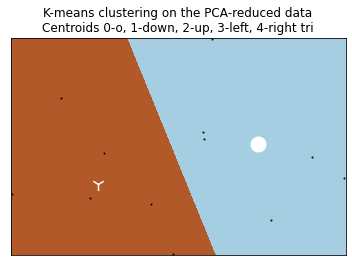

In [ ]:
X_pix_raw, filenames = to_feature_maps('/content/ClassifyImages/data/cars', file_type='*', use_fm=False)

X_pix = X_pix_raw / 256

# X_pix_flatten = X_pix.reshape(X_pix.shape[0], -1)

K = 2

# dimensionality reduction through PCA
X_reduced_pix, pca_pix = get_pca_reduced(X_pix, dimensions=2)

X_clusters_pix, kmeans_pix = get_clusters(X_reduced_pix, 2)


# get the image ids of each cluster
cluster_idx_pix = to_cluster_idx(X_clusters_pix.labels_, [0, 1])

# keep the cluster centers
print(kmeans_pix.cluster_centers_)
print(cluster_idx_pix)

plot_pca_clusters(X_reduced_pix, kmeans=kmeans_pix)

In [ ]:
def plot_data_in_clusters(data, kmeans, idx):
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = data[:, 0].min() - 3, data[:, 0].max() + 3
    y_min, y_max = data[:, 1].min() - 3, data[:, 1].max() + 3
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(2)
    # plt.clf()
    plt.imshow(Z, interpolation="nearest",
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                cmap=plt.cm.Paired, aspect="auto", origin="lower")

    plt.plot(data[:, 0], data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    # centroids = kmeans.cluster_centers_

    # markers = ["o", "1", "2", "3", "4"]
    # for id in range(len(centroids)):
    #   c = centroids[id]
    #   plt.scatter(c[0], c[1], marker=markers[id], s=169, linewidths=3,
    #               color="w", zorder=10)
    for id in idx:
        plt.scatter(data[id, 0], data[id, 1], marker="x",
                    s=169, linewidths=3,
                    color="w", zorder=10)

    # plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
    #             color="w", zorder=10)
    # https://matplotlib.org/2.0.2/api/markers_api.html#module-matplotlib.markers
    plt.title("K-means clustering plot")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [ ]:
def find_min_max(X_data):
  # Calculate distances of all points
  distances = cdist(X_data, X_data)

  rows = distances.shape[0]

  max_id1 = int(np.argmax(distances)/rows)
  max_id2 = np.argmax(distances[max_id1])

  # use the max value to set the zero value of the diagonal 
  max = np.max(distances)

  for row_id in range(distances.shape[0]):
    distances[row_id, row_id] = max

  min_id1 = int(np.argmin(distances)/distances.shape[0])
  min_id2 = np.argmin(distances[min_id1])

  print("min: {} {}".format((min_id1, min_id2), distances[min_id1, min_id2]))
  print("max: {} {}".format((max_id1, max_id2), distances[max_id1, max_id2]))

  return (min_id1, min_id2), (max_id1, max_id2)

(min_id1, min_id2), (max_id1, max_id2) = find_min_max(X_reduced_pix)

min: (3, 5) 1.7986557902095437
max: (0, 10) 83.82105760394228


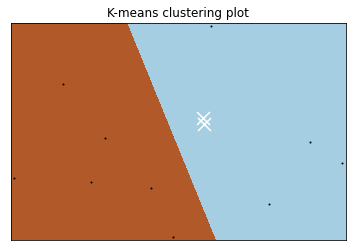

In [ ]:
plot_data_in_clusters(X_reduced_pix, kmeans_pix, [3, 5])

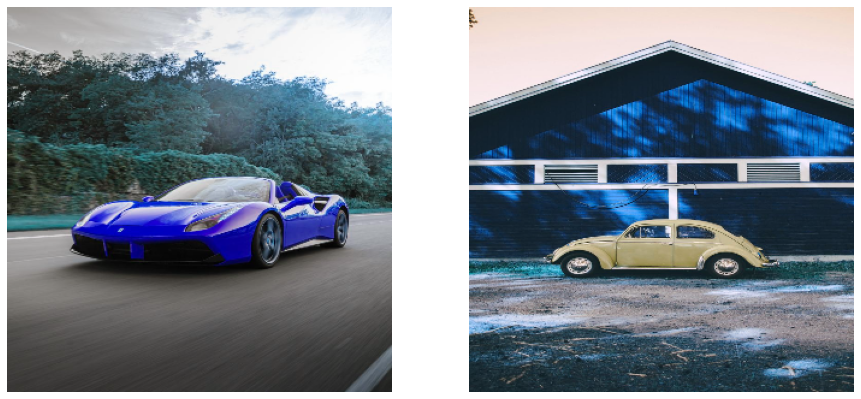

In [ ]:
plot_images(X_pix, idx=[3, 5])

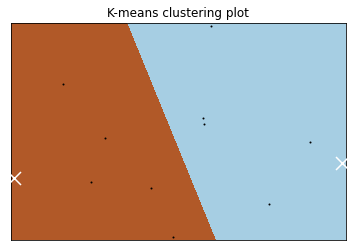

In [ ]:
plot_data_in_clusters(X_reduced_pix, kmeans_pix, [0, 10] )

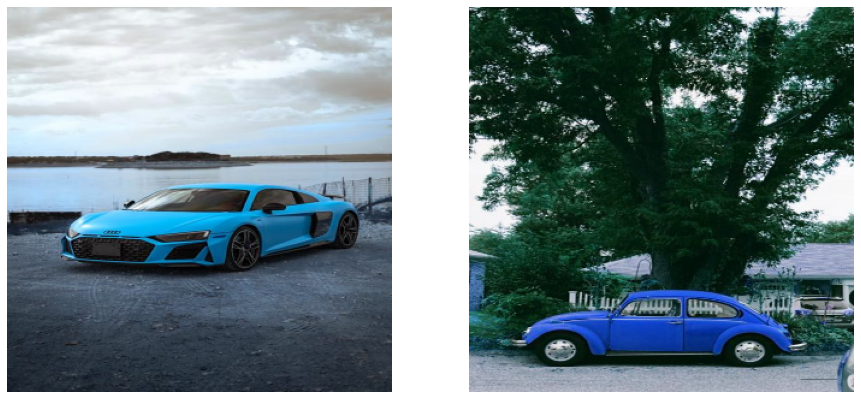

In [ ]:
plot_images(X_pix, idx=[0, 10])

# Cluster Using Feature Maps

/content/ClassifyImages/data/cars/audi.brandon-atchison-eBJWhlqWR54-unsplash.jpg
/content/ClassifyImages/data/cars/ferrari.goh-rhy-yan-f_SDCASisgs-unsplash.jpg
/content/ClassifyImages/data/cars/ferrari.lance-asper-dxJ80oNvnhE-unsplash.jpg
/content/ClassifyImages/data/cars/ferrari.martin-katler-WTN4tbN_tNQ-unsplash.jpg
/content/ClassifyImages/data/cars/vw.chris-barbalis-699z9mRKlA8-unsplash.jpg
/content/ClassifyImages/data/cars/vw.christer-ehrling-5eiFysR9B8k-unsplash.jpg
/content/ClassifyImages/data/cars/vw.dan-gold-N7RiDzfF2iw-unsplash.jpg
/content/ClassifyImages/data/cars/vw.dan-gold-Q_2p94h8rjI-unsplash.jpg
/content/ClassifyImages/data/cars/vw.emil-diallo-H-Y7mdumq1w-unsplash.jpg
/content/ClassifyImages/data/cars/vw.martin-katler-V58Dl1fv42c-unsplash.jpg
/content/ClassifyImages/data/cars/vw.moriah-wolfe-75_17YO8i5s-unsplash.jpg
/content/ClassifyImages/data/cars/vw.tom-arrowsmith-7HNftpNvqho-unsplash.jpg
#### (12, 1, 10, 10, 512)
(12, 51200)
[[ 0.54414535 -0.21543089]
 [-0.18138178  

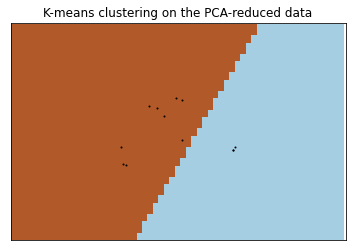

In [ ]:
X_fm, filenames = to_feature_maps('/content/ClassifyImages/data/cars', file_type='*')
print("####", X_fm.shape)

# normalize to use cosine similarity
X_fm_normalized = preprocessing.normalize(X_fm.reshape(len(X_fm), -1))

print(X_fm_normalized.shape)

# number of clusters
K = 2

# dimensionality reduction through PCA
X_fm_reduced, pca_fm = get_pca_reduced(X_fm_normalized, dimensions=2)


X_clusters_fm, kmeans_fm = get_clusters(X_fm_reduced, 2)

# get the image ids of each cluster
cluster_idx_fm = to_cluster_idx(X_clusters_fm.labels_, [0, 1])

# keep the cluster centers
print(kmeans_fm.cluster_centers_)
print(cluster_idx_fm)

plot_pca_clusters(X_fm_reduced, kmeans=kmeans_fm)

In [ ]:
(min_id1, min_id2), (max_id1, max_id2) = find_min_max(X_fm_reduced)

min: (2, 3) 0.004911000144038469
max: (0, 10) 1.032619381845017


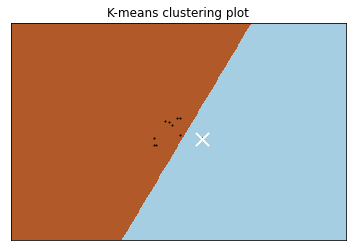

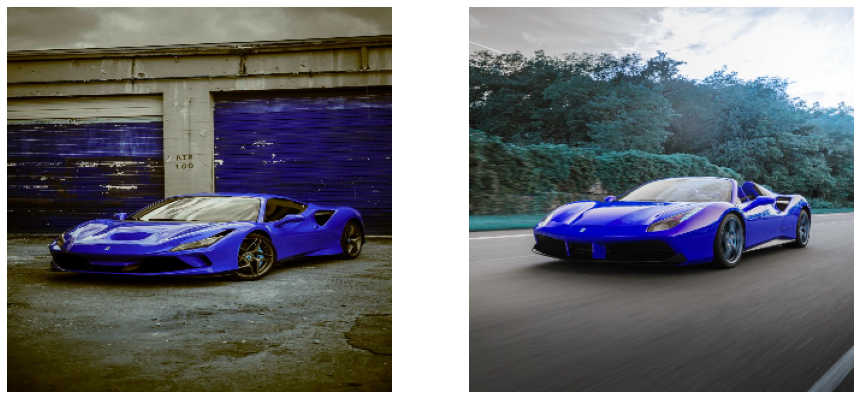

In [ ]:
plot_data_in_clusters(X_fm_reduced, kmeans_fm, [2, 3])
plot_images(X_pix, idx=[2, 3])

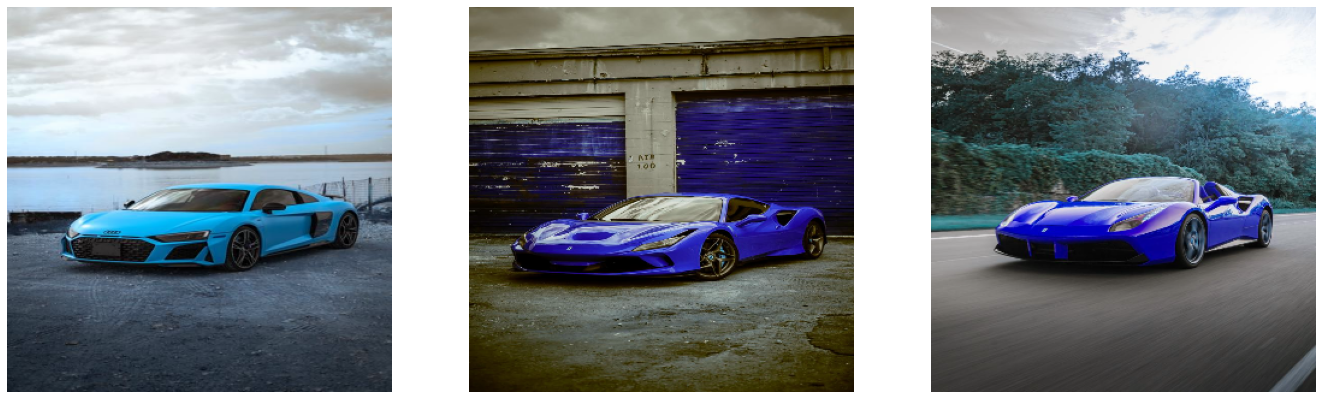

In [ ]:
plot_images(X_pix, idx=cluster_idx_fm[0])

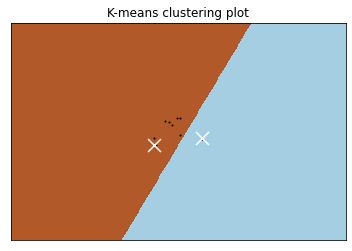

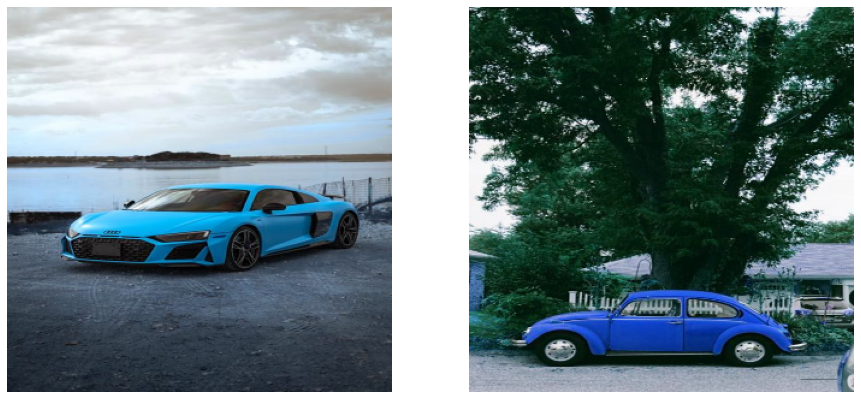

In [ ]:
plot_data_in_clusters(X_fm_reduced, kmeans_fm, [0, 10])
plot_images(X_pix, idx=[0, 10])

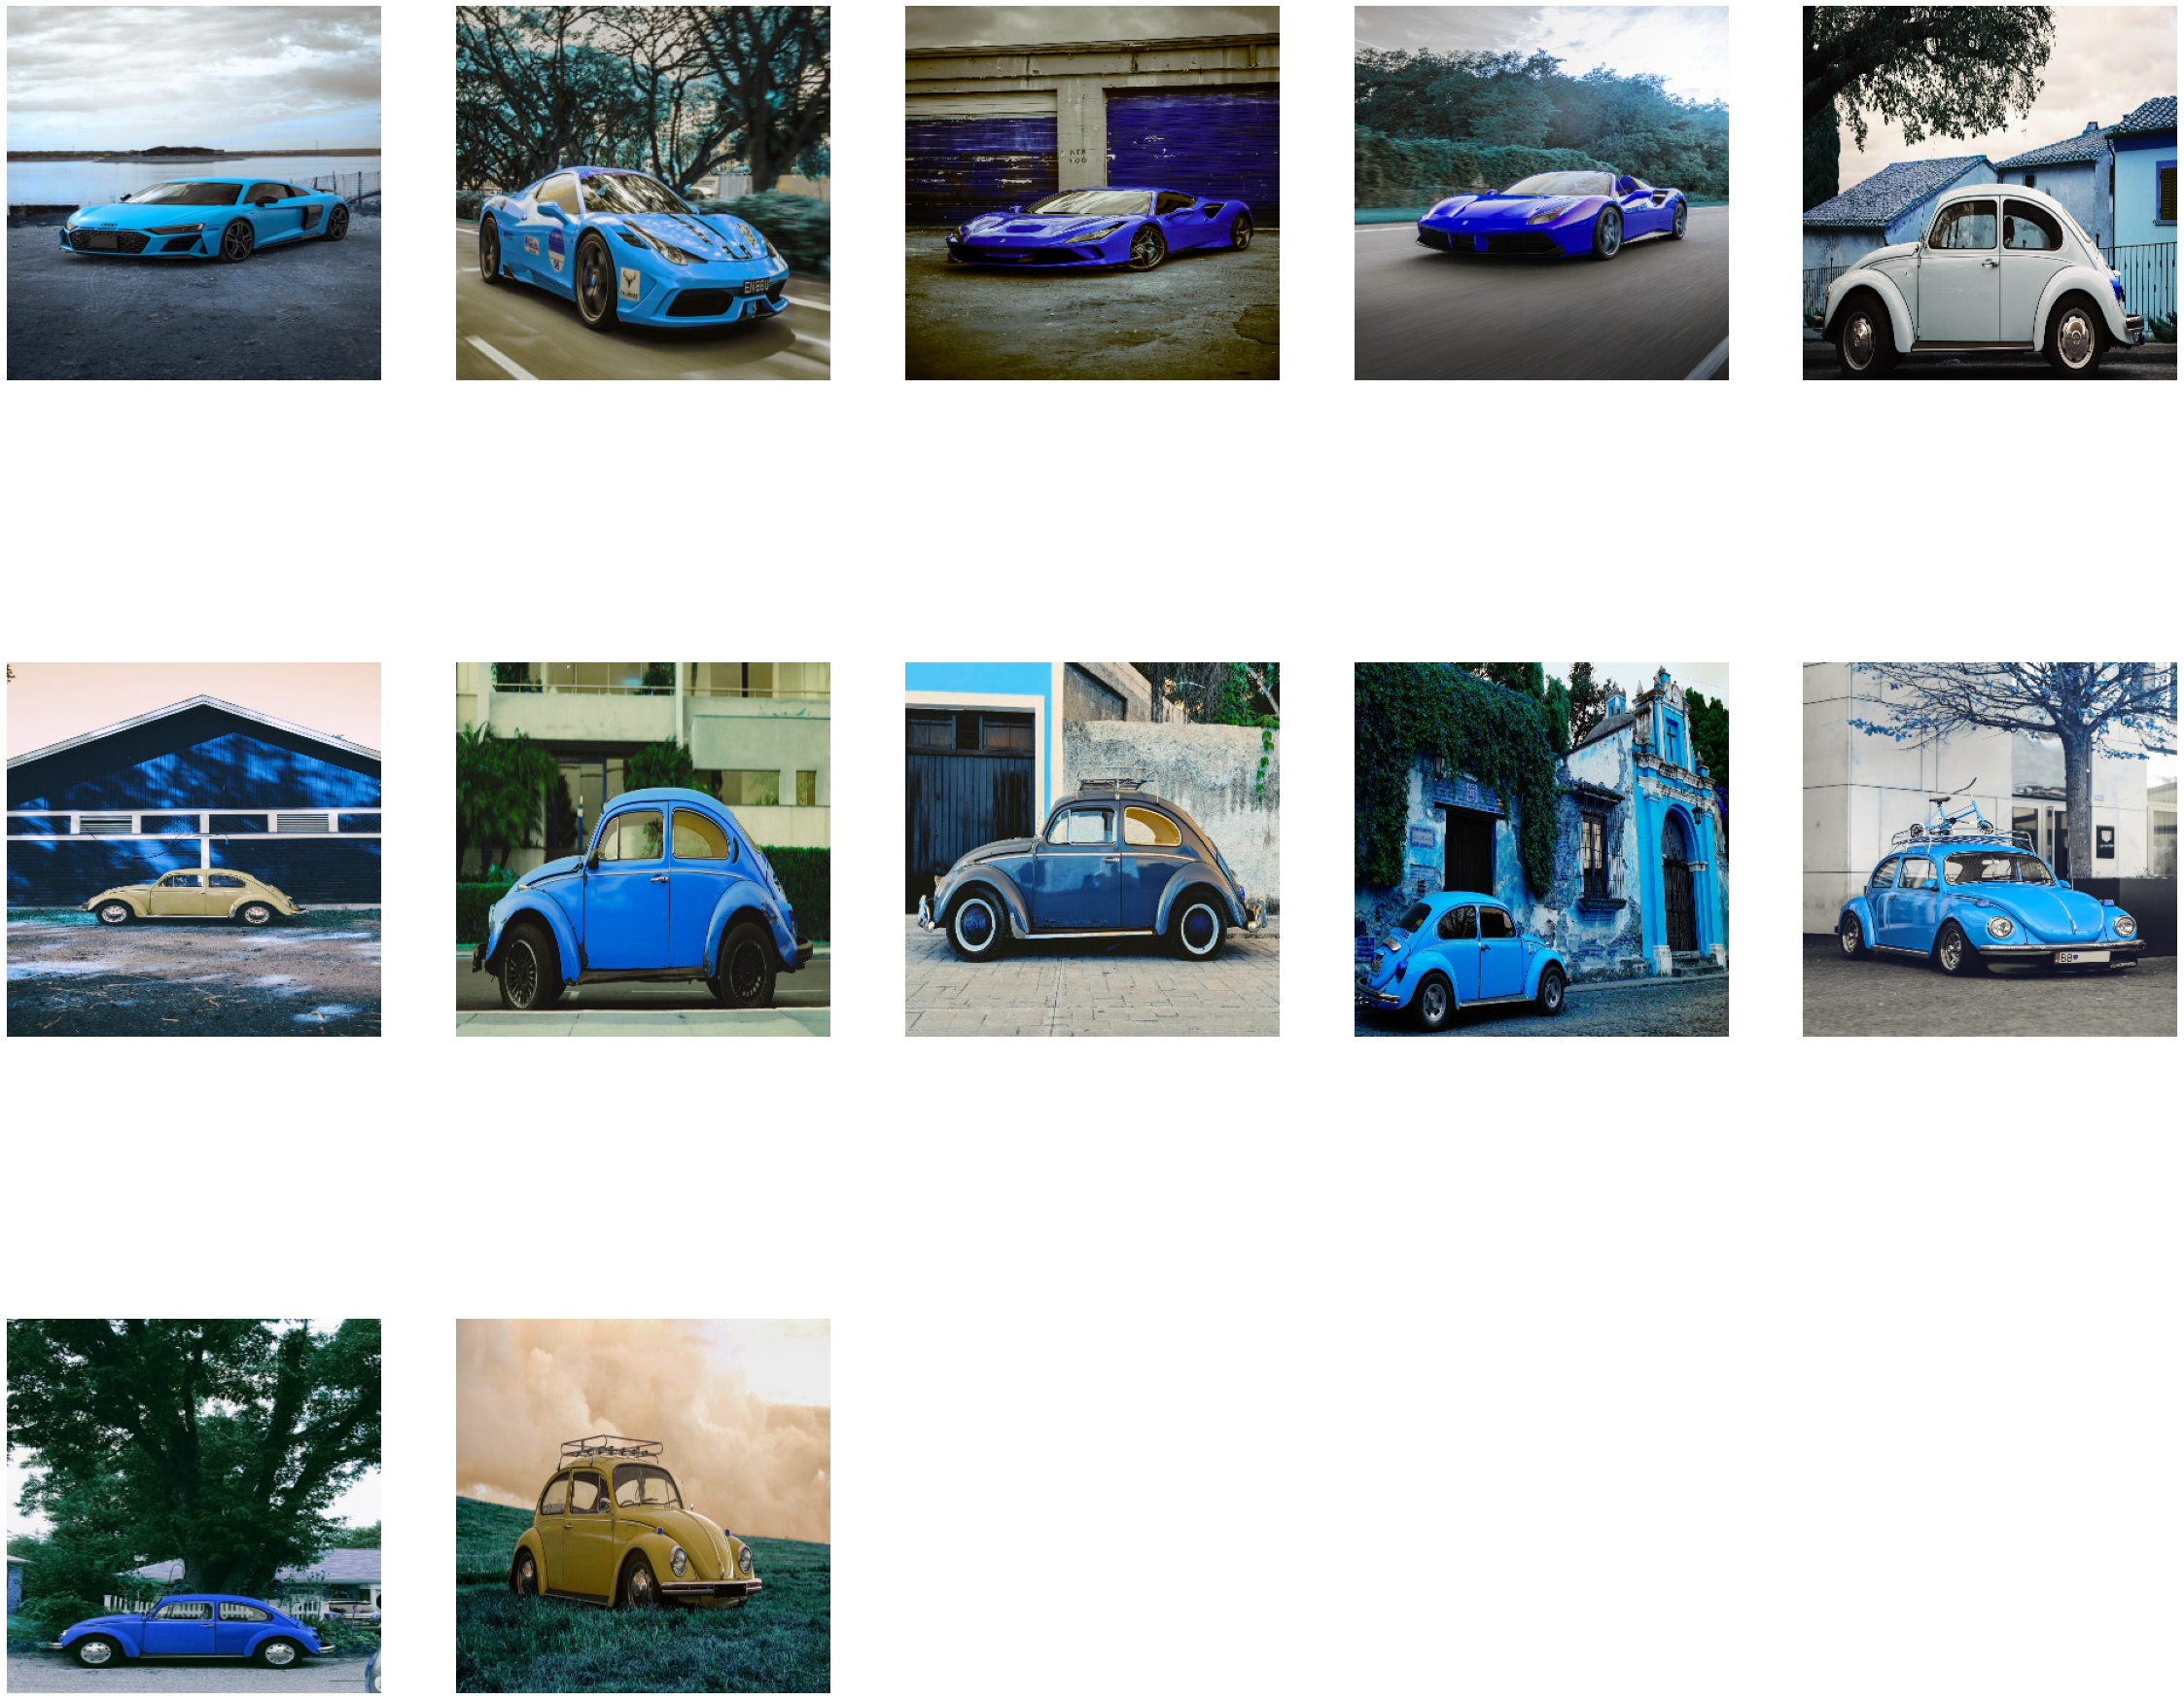

In [ ]:
plot_images(X_pix)

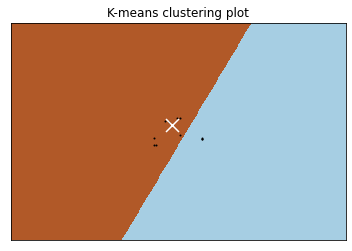

In [ ]:
plot_data_in_clusters(X_fm_reduced, kmeans_fm, [1])

In [ ]:
X_fm, filenames = to_feature_maps('/content/DLTrafficCounter/data/bbox_highway/test', file_type='*')
print("####", X_fm.shape)

/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_096.png
58900480/58889256 [==============================] - 1s 0us/step
(1, 10, 10, 512)
/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_096.txt
/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_096.txt  is not an image file
/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_097.png
(1, 10, 10, 512)
/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_097.txt
/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_097.txt  is not an image file
/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_098.png
(1, 10, 10, 512)
/content/DLTrafficCounter/data/bbox_highwa

In [ ]:
# normalize to use cosine similarity
X_fm_normalized = preprocessing.normalize(X_fm.reshape(len(X_fm), -1))

print(X_fm_normalized.shape)

# number of clusters
K = 2

# dimensionality reduction through PCA
X_reduced, pca = get_pca_reduced(X_fm_normalized, dimensions=2)

(12, 51200)


In [ ]:
X_reduced_euc, pca_euc = get_pca_reduced(X_fm, dimensions=2)

In [ ]:
fm, filenames = to_feature_maps('/content/test', file_type='*')
print(fm.shape)

/content/test/2photo-pots-vT9SSvrAncY-unsplash.jpg
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_poo

In [ ]:
fm, filenames = to_feature_maps('/content/test', file_type='*')
print(fm.shape)

/content/test/2photo-pots-vT9SSvrAncY-unsplash.jpg
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________
(1, 320, 320, 64)
(1, 1, 320, 320, 64)


In [ ]:
X_fm, filenames = to_feature_maps('/content/DLTrafficCounter/data/bbox_highway/test', file_type='*')
print("####", X_fm.shape)

/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_096.png
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________
(1, 320, 320, 64)
/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_096.txt
/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_096.txt  is not an image file
/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_097.png
Model: "model_4"
______

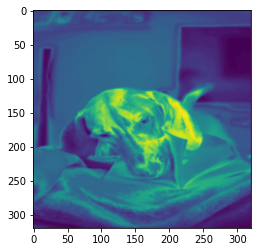

In [ ]:
import matplotlib.pyplot as plt


# plt.imshow(X_fm[0][0][:, :, 0])

# X_fm[0][0].reshape(320, 160).shape

plt.imshow(fm[0][0][:, :, 1])

# plt.imshow(fm[0][0][:, :, 0])


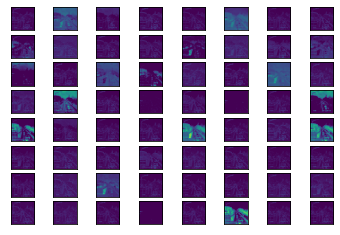

In [ ]:
ROWS = 8
COLUMNS = 8
for fmap in X_fm[0]:
  # plot all 64 maps in an 8x8 squares
  ix = 1
  for _ in range(ROWS):
    for _ in range(COLUMNS):
      # specify subplot and turn of axis
      ax = plt.subplot(ROWS, COLUMNS, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      # plot filter channel in grayscale
      # print(fmap.shape)
      plt.imshow(fmap[:, :, ix-1])
      ix += 1
# show the figure
plt.show()

In [ ]:
X_features = cluster_images('/content/DLTrafficCounter/data/bbox_highway/test')

/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_096.png
(320, 320, 3)
(1, 10, 10, 512)
/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_097.png
(320, 320, 3)
(1, 10, 10, 512)
/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_098.png
(320, 320, 3)
(1, 10, 10, 512)
/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_099.png
(320, 320, 3)
(1, 10, 10, 512)
/content/DLTrafficCounter/data/bbox_highway/test/Suwon_CH02_20200722_1600_WED_9m_RH_highway_TW5_rainy_FHD_100.png
(320, 320, 3)
(1, 10, 10, 512)


In [ ]:
# X_reduced = X_reduced.reshape(-1, 1)
X_features_flatten = X_features.reshape(X_features.shape[0], -1)

X_clusters, kmeans = get_clusters(X_features_flatten, 2)

In [ ]:
# cluster
X_clusters, kmeans = get_clusters(X_reduced, 2)

# get the image ids of each cluster
cluster_idx = to_cluster_idx(X_clusters.labels_, [0, 1])

# keep the cluster centers
print(kmeans.cluster_centers_)
print(cluster_idx)

[[-4.5856735e-01 -1.6710158e-04]
 [ 5.0122488e-01  1.8265484e-04]]
{0: array([ 2,  3,  4,  5,  6,  7, 14, 15, 16, 17, 18, 19, 26, 27, 28, 29, 30,
       31, 37, 38, 39, 40, 41, 42, 49, 50, 51, 52, 53, 54, 61, 62, 63, 64,
       65, 66, 73, 74, 75, 76, 77, 78, 85, 86, 87, 88, 89]), 1: array([ 0,  1,  8,  9, 10, 11, 12, 13, 20, 21, 22, 23, 24, 25, 32, 33, 34,
       35, 36, 43, 44, 45, 46, 47, 48, 55, 56, 57, 58, 59, 60, 67, 68, 69,
       70, 71, 72, 79, 80, 81, 82, 83, 84])}


# Plot clusters


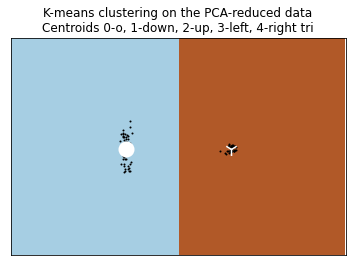

In [ ]:
plot_pca_clusters(X_reduced, kmeans)

In [ ]:
X_clusters.cluster_centers_

array([[-4.5856735e-01, -1.6710158e-04],
       [ 5.0122488e-01,  1.8265484e-04]], dtype=float32)

In [ ]:
# cluster
X_clusters, kmeans = get_clusters(X_reduced, 2)

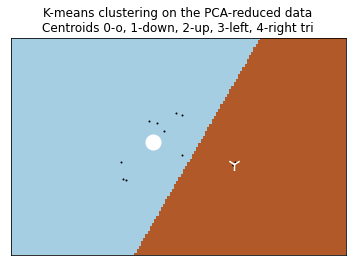

In [ ]:
plot_pca_clusters(X_reduced, kmeans)

In [ ]:
to_cluster_idx(X_clusters.labels_, range(2))

{0: array([ 1,  2,  3,  4,  5,  6,  8, 10, 11]), 1: array([0, 7, 9])}

In [ ]:
X_clusters_euc, kmeans_euc = get_clusters(X_reduced_euc, 2)

NameError: ignored

In [ ]:
plot_pca_clusters(X_reduced_euc, kmeans_euc)

In [ ]:
X_clusters_euc, kmeans_euc = get_clusters(X_reduced_euc, 2)